# Predicting Salaries from Job Postings: A Machine Learning Approach

## Evaluating Predictive Models for Job Salaries Using Text-based and Numeric Features

Salary prediction. The data set includes information on job postings. Use this data set to predict the salary of a job posting (i.e., the `Salary` column in the data set) based on the job description and other attributes of the job. This is important, because this model can make a salary recommendation as soon as a job posting is entered into a system.

## Description of Variables

The description of variables are provided in "Jobs - Data Dictionary.docx"

## Goal

Use the **jobs_alldata.csv** data set and build models to predict **salary**.

# Section 1: (8 points in total)

## Data Prep (6 points)

## Setup

In [ ]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)

## Get the data

In [ ]:
#We will predict the "price" value in the data set:

jobs = pd.read_csv("jobs_alldata.csv")
jobs.head()

#### Inspecting the target Variable

In [ ]:
jobs['Salary'].describe()

In [ ]:
jobs['Salary'].hist(bins=75)

Removing the outlier where salary = 3624

In [ ]:
jobs = jobs.loc[jobs["Salary"] != 3624]

In [ ]:
jobs['Salary'].describe()

In [ ]:
jobs['Salary'].hist(bins=75)

## Split the data into train and test

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(jobs, test_size=0.3)

In [ ]:
train_set.shape, test_set.shape

## Check the missing values

In [ ]:
train_set.isna().sum()

In [ ]:
test_set.isna().sum()

There are no missing values in the current dataset.

## Data Prep

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use.

In [ ]:
# We can't use the following columns in this tutorial, because they are for classification tasks

train = train_set.drop(['Job Description'], axis=1)
test = test_set.drop(['Job Description'], axis=1)

In this case, the text variable will be dropped in order to make changes separately and then concatenate them before finding the baseline and implementing the model.

## Separate the target variable (we don't want to transform it)

In [ ]:
train_y = train[['Salary']]
test_y = test[['Salary']]

train_inputs = train.drop(['Salary'], axis=1)
test_inputs = test.drop(['Salary'], axis=1)

## Feature Engineering (1 points)

Create one NEW feature from existing data. You either transform a single variable, or create a new variable from existing ones. 

Grading: 
- 0.5 points for creating the new feature correctly
- 0.5 points for the justification of the new feature (i.e., why did you create this new feature)

In [ ]:
# Let's analyze "Min_years_exp"

train_inputs['Min_years_exp'].describe()

In [ ]:
train_inputs['Min_years_exp'].value_counts()

In [ ]:
train_inputs['Min_years_exp'].hist()

#### Creating a new binary column: if the job requires a minimum of 1-2 years of experience, it is 1 (entry level), otherwise, 0 (experience required).

### Justification: Since the Min_years_exp column shows a bimodal distribution, I would give more weight to entry-level jobs (1-2 years) and jobs requiring a minimum of three to five years of experience. 1 indicates entry-level postings (otherwise is 0).

In [ ]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['entry_level_binary'] = np.where(df1['Min_years_exp'] <= 2, 1, 0)
    
    return df1[['entry_level_binary']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

In [ ]:
#Let's test the new function:

# Send train set to the function we created
new_col(train_set).value_counts()

##  Identify the numerical and categorical columns

In [ ]:
train_inputs.dtypes

In [ ]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [ ]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = []

In [ ]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [ ]:
binary_columns

In [ ]:
numeric_columns

In [ ]:
categorical_columns

In [ ]:
feat_eng_columns = ['Min_years_exp']

## Pipeline

In [ ]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [ ]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [ ]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

## Transform: fit_transform() for TRAIN

In [ ]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

In [ ]:
train_x.shape

## Tranform: transform() for TEST

In [ ]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

In [ ]:
test_x.shape

## - Text Processing

### Assign the "target" variable for text processing

In [ ]:
target_text = jobs['Salary']

### Assign the "text" (input) variable

In [ ]:
# Check for missing values

jobs[['Job Description']].isna().sum()

In [ ]:
# If there were missing values:

#jobs['Job Description'].fillna('missing', inplace=True)

In [ ]:
input_data = jobs['Job Description']

### Split the text data

In [ ]:
from sklearn.model_selection import train_test_split

train_set_text, test_set_text, train_y_text, test_y_text = train_test_split(input_data, target_text, test_size=0.3, random_state=42)

In [ ]:
train_set_text.shape, train_y_text.shape

In [ ]:
test_set_text.shape, test_y_text.shape

### Sklearn: Text preparation

In [ ]:
#TfidfVectorizer includes pre-processing, tokenization, filtering stop words
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(stop_words='english')

train_x_tr = tfidf_vect.fit_transform(train_set_text)

In [ ]:
# Perform the TfidfVectorizer transformation
# Be careful: We are using the train fit to transform the test data set. Otherwise, the test data 
# features will be very different and match the train set!!!

test_x_tr = tfidf_vect.transform(test_set_text)

In [ ]:
train_x_tr.shape, test_x_tr.shape

### Latent Semantic Analysis on text column (Singular Value Decomposition)

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
#If you are performing Latent Semantic Analysis, recommended number of components is 100

svd = TruncatedSVD(n_components=150, n_iter=100)

In [ ]:
train_x_lsa = svd.fit_transform(train_x_tr)

In [ ]:
train_x_lsa.shape

### Variance after SVD

In [ ]:
svd.explained_variance_.sum()

### Transforming the TEXT test data set 

In [ ]:
test_x_lsa = svd.transform(test_x_tr)

In [ ]:
test_x_lsa.shape

In [ ]:
##Print the last 10 terms (i.e., the 10 terms that have the highest weigths)
first_component = svd.components_[0,:]
indeces = np.argsort(first_component).tolist()
#Let's get the feature names from the count vectorizer:
feat_names = tfidf_vect.get_feature_names()

for index in indeces[-10:]:
    print(feat_names[index], "\t\tweight =", first_component[index])

Until here, we have 2 arrays. One for the previous numeric/categorical/binary dataset and 1 for only the text data processed using SVD. As a result of reducing the number of columns from 9910 to 150 in the text processing, the Variance means that those 150 columns can explain ~50% of the initial raw text.

## - Concatenate the procesesed colums: Text and numerical/categotical/binary columns into only one dataset

#### For train

In [ ]:
train_x.shape, train_x_lsa.shape

In [ ]:
train_combined = np.concatenate((train_x,train_x_lsa), axis=1)

In [ ]:
train_combined.shape

#### For Test

In [ ]:
test_x.shape, test_x_lsa.shape

In [ ]:
test_combined = np.concatenate((test_x,test_x_lsa), axis=1)

In [ ]:
test_combined.shape

## Find the Baseline (1 point)

In [ ]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(train_combined, train_y)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
train_combined.shape, train_y.shape

In [ ]:
#Baseline Train RMSE
dummy_train_pred = dummy_regr.predict(train_combined)

baseline_train_mse = mean_squared_error(train_y, dummy_train_pred)

baseline_train_rmse = np.sqrt(baseline_train_mse)

print('Baseline Train RMSE: {}' .format(baseline_train_rmse))

In [ ]:
#Baseline Test RMSE
dummy_test_pred = dummy_regr.predict(test_combined)

baseline_test_mse = mean_squared_error (test_y, dummy_test_pred)

baseline_test_rmse = np.sqrt(baseline_test_mse)

print('Baseline Test RMSE: {}' .format(baseline_test_rmse))


# Section 2: (7 points in total)

Build the following models:


## 2.1 Decision Tree using Randomized Grid Search: (1 point)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'min_samples_leaf': np.arange(1, 50), 
     'max_depth': np.arange(1,100)}
  ]

tree_reg = DecisionTreeRegressor()

grid_search = RandomizedSearchCV(tree_reg, param_grid, cv=6, n_iter=50,
                           scoring='neg_mean_squared_error', verbose=1,
                           return_train_score=True)

grid_search.fit(train_combined, train_y)

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
#Train RMSE
train_pred = grid_search.best_estimator_.predict(train_combined)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

model_1_train_rmse = train_rmse

In [ ]:
#Test RMSE
test_pred = grid_search.best_estimator_.predict(test_combined)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

model_1_test_rmse = test_rmse

### Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform cross-validation using 5 folds
cv_scores = cross_val_score(grid_search, train_combined, train_y, cv=5, scoring='neg_mean_squared_error')

#Take the average of the negative mean squared error scores to get the mean squared error
mse = -np.mean(cv_scores)
rmse = np.sqrt(mse)
print("Mean Squared Error: ", rmse)

## 2.2 Voting regressor (2 points):

The voting regressor should have at least 3 individual models

### Voting Regressor - Individual Model 1

In [ ]:
from sklearn.linear_model import SGDRegressor 
from sklearn.svm import SVR 
from sklearn.ensemble import VotingRegressor


dtree_reg = DecisionTreeRegressor(max_depth=20)
svm_reg = SVR(kernel="rbf", C=10, epsilon=0.01, gamma='scale') 
sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3)

voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg), 
                        ('svr', svm_reg), 
                        ('sgd', sgd_reg)])

voting_reg.fit(train_combined, train_y)

In [ ]:
#Train RMSE
train_pred = voting_reg.predict(train_combined)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

model_2_train_rmse = train_rmse

In [ ]:
#Test RMSE
test_pred = voting_reg.predict(test_combined)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

model_2_test_rmse = test_rmse

In [ ]:
for reg in (dtree_reg, svm_reg, sgd_reg, voting_reg):
    reg.fit(train_combined, train_y['Salary'])
    test_y_pred = reg.predict(test_combined)
    print(reg.__class__.__name__, 'Test rmse=', np.sqrt(mean_squared_error(test_y, test_y_pred)))

### Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform cross-validation using 5 folds
cv_scores = cross_val_score(voting_reg, train_combined, train_y, cv=5, scoring='neg_mean_squared_error')

#Take the average of the negative mean squared error scores to get the mean squared error
mse = -np.mean(cv_scores)
rmse_1 = np.sqrt(mse)
print("Mean Squared Error: ", rmse_1)

### Voting Regressor with weights - Individual Model 2

In [120]:
dtree_reg = DecisionTreeRegressor(max_depth=20)
svm_reg = SVR(kernel="rbf", C=10, epsilon=0.01, gamma='scale') 
sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3)

voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg), ('svr', svm_reg), ('sgd', sgd_reg)],
                        weights=[0.6, 0.2, 0.2])

voting_reg.fit(train_combined, train_y)

/Users/pablozumba/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('dt', DecisionTreeRegressor(max_depth=20)),
                            ('svr', SVR(C=10, epsilon=0.01)),
                            ('sgd', SGDRegressor(max_iter=10000))],
                weights=[0.6, 0.2, 0.2])

In [121]:
#Train RMSE
train_pred = voting_reg.predict(train_combined)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

model_3_train_rmse = train_rmse

Train RMSE: 9227.239353172086


In [122]:
#Test RMSE
test_pred = voting_reg.predict(test_combined)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

model_3_test_rmse = test_rmse

Test RMSE: 19255.856594905177


### Cross Validation

In [123]:
from sklearn.model_selection import cross_val_score
#Perform cross-validation using 5 folds
cv_scores = cross_val_score(voting_reg, train_combined, train_y, cv=5, scoring='neg_mean_squared_error')

#Take the average of the negative mean squared error scores to get the mean squared error
mse = -np.mean(cv_scores)
rmse_2 = np.sqrt(mse)
print("Mean Squared Error: ", rmse_2)

/Users/pablozumba/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pablozumba/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pablozumba/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pablozumba/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d

Mean Squared Error:  21692.063437999772


### Voting Regressor with weights - Individual Model 3

In [ ]:
dtree_reg = DecisionTreeRegressor(max_depth=50)
svm_reg = SVR(kernel="rbf", C=5, epsilon=0.9, gamma='scale') 
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3)

voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg), ('svr', svm_reg), ('sgd', sgd_reg)],
                        weights=[0.6, 0.2, 0.2])

voting_reg.fit(train_combined, train_y)

In [ ]:
#Train RMSE
train_pred = voting_reg.predict(train_combined)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

model_4_train_rmse = train_rmse

In [ ]:
#Test RMSE
test_pred = voting_reg.predict(test_combined)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

model_4_test_rmse = test_rmse

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform cross-validation using 5 folds
cv_scores = cross_val_score(voting_reg, train_combined, train_y, cv=5, scoring='neg_mean_squared_error')

#Take the average of the negative mean squared error scores to get the mean squared error
mse = -np.mean(cv_scores)
rmse_3 = np.sqrt(mse)
print("Mean Squared Error: ", rmse_3)

## 2.3 A Boosting model: (1 point)

Build either an Adaboost or a GradientBoost model

### Gradient Boosting Regressor with early stopping

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
#Notice that learning rate and tol are high to see early stopping
gb_reg = GradientBoostingRegressor(max_depth=10, n_estimators=500, 
                                   learning_rate=0.75, 
                                  tol=0.1, n_iter_no_change=5, validation_fraction=0.2,
                                  verbose=1) 

gb_reg.fit(train_combined, train_y['Salary'])

In [ ]:
gb_reg.n_estimators_

In [ ]:
#Train RMSE
train_pred = gb_reg.predict(train_combined)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

model_5_train_rmse = train_rmse

In [ ]:
#Test RMSE
test_pred = gb_reg.predict(test_combined)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

model_5_test_rmse = test_rmse

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform cross-validation using 5 folds
cv_scores = cross_val_score(gb_reg, train_combined, train_y, cv=5, scoring='neg_mean_squared_error')

#Take the average of the negative mean squared error scores to get the mean squared error
mse = -np.mean(cv_scores)
rmse_4 = np.sqrt(mse)
print("Mean Squared Error: ", rmse_4)

## 2.4 Extreme Gradient Boosting (XGBoost)

In [ ]:
import xgboost

In [ ]:
xgb_reg = xgboost.XGBRegressor(max_depth = 4, min_child_weight = 2, reg_alpha=150)

xgb_reg.fit(train_combined, train_y)

In [ ]:
#Train RMSE
train_pred = xgb_reg.predict(train_combined)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

model_6_train_rmse = train_rmse

In [ ]:
#Test RMSE
test_pred = xgb_reg.predict(test_combined)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

model_6_test_rmse = test_rmse

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform cross-validation using 5 folds
cv_scores = cross_val_score(xgb_reg, train_combined, train_y, cv=5, scoring='neg_mean_squared_error')

#Take the average of the negative mean squared error scores to get the mean squared error
mse = -np.mean(cv_scores)
rmse_5 = np.sqrt(mse)
print("Mean Squared Error: ", rmse_5)

## 2.5 Neural network: (1 point)

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(hidden_layer_sizes=(50,), max_iter=5000)

mlp_reg.fit(train_combined, train_y)

In [ ]:
#Train RMSE
train_pred = mlp_reg.predict(train_combined)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

model_7_train_rmse = train_rmse

In [ ]:
#Test RMSE
test_pred = mlp_reg.predict(test_combined)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

model_7_test_rmse = test_rmse

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform cross-validation using 5 folds
cv_scores = cross_val_score(mlp_reg, train_combined, train_y, cv=5, scoring='neg_mean_squared_error')

#Take the average of the negative mean squared error scores to get the mean squared error
mse = -np.mean(cv_scores)
rmse_6 = np.sqrt(mse)
print("Mean Squared Error: ", rmse_6)

## 2.6 Grid search on XGBoost(2 points)

Perform either a full or randomized grid search on any model you want. There has to be at least two parameters for the search. 

New Tasks:
- TO reduce overfitting in XGBoost, use grid search and max_depth, min_child_weight, reg_alpha

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'max_depth': np.arange(1, 100), 
     'min_child_weight': np.arange(1,10),
     'reg_alpha': np.arange(50,200)}
  ]

grid_search = RandomizedSearchCV(xgb_reg, param_grid, cv=2, n_iter=2,
                           scoring='neg_mean_squared_error', verbose=1,
                           return_train_score=True)

grid_search.fit(train_combined, train_y)

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
#Train RMSE
train_pred = grid_search.best_estimator_.predict(train_combined)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

model_8_train_rmse = train_rmse

In [ ]:
#Test RMSE
test_pred = grid_search.best_estimator_.predict(test_combined)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

model_8_test_rmse = test_rmse

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform cross-validation using 5 folds
cv_scores = cross_val_score(grid_search, train_combined, train_y, cv=5, scoring='neg_mean_squared_error')

#Take the average of the negative mean squared error scores to get the mean squared error
mse = -np.mean(cv_scores)
rmse_7 = np.sqrt(mse)
print("Mean Squared Error: ", rmse_7)

# Section 3: Discussion (5 points in total)


## List the train and test values of each model you built (2 points)

In [124]:
import matplotlib.pyplot as plt

# Define the accuracy values for each model
model_names = ['DTree using RGS', 'Voting Regr1', 'Voting Regr2', 'Voting Regr3', 'Grad Boost Regr', 'XGBoost', 'Neural Network', 'Grid Search on XGBoost']
train_list_rmse = [model_1_train_rmse, model_2_train_rmse, model_3_train_rmse, model_4_train_rmse, model_5_train_rmse, model_6_train_rmse, model_7_train_rmse, model_8_train_rmse]
test_list_rmse = [model_1_test_rmse, model_2_test_rmse, model_3_test_rmse, model_4_test_rmse, model_5_test_rmse, model_6_test_rmse, model_7_test_rmse, model_8_test_rmse]

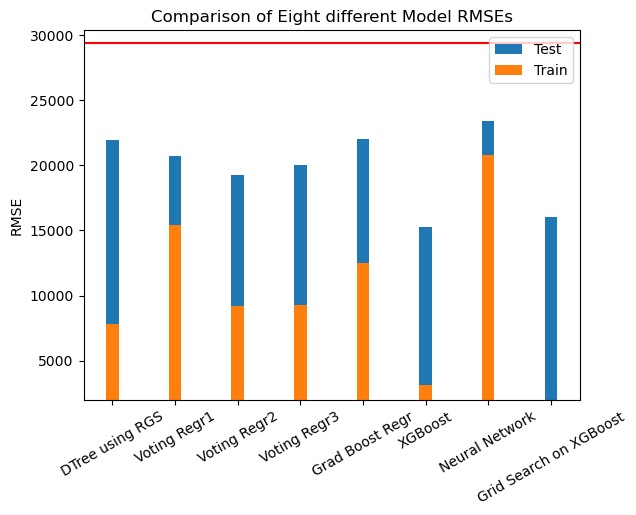

In [125]:

#Create the bar chart
fig, ax = plt.subplots()
bar_width = 0.2
bar1 = ax.bar(model_names, test_list_rmse, bar_width, label='Test')
bar2 = ax.bar(model_names, train_list_rmse, bar_width, label='Train')
#plt.xticks(model_names, model_names, rotation=45)

#Add labels and title
plt.title('Comparison of Eight different Model RMSEs')
ax.set_ylabel('RMSE')
plt.ylim(2000, baseline_test_rmse + 1000)
ax.legend()

#Define the Baseline test accuracy as reference
ax.axhline(y = baseline_test_rmse, color = 'r', linestyle = '-')

#Make the X axis more readable
plt.xticks(model_names, model_names, rotation=30)

#Show the chart
plt.show()

In [126]:
test_list_rmse

[21920.423961150747,
 20694.356494265496,
 19255.856594905177,
 20019.933355483405,
 22013.947199289298,
 15294.340342132948,
 23420.476936184714,
 16058.580938177454]

## Which model performs the best and why? (0.5 points) 

Hint: The best model is the one that has the lowest TEST RMSE value (regardless of any of the training values). If you select your model based on TRAIN values, you will lose points.

**The model that performs the best is the XGBoost, giving a +/- 15k error on predicting a salary. I tested all models without taking into account the text column and failed to beat the baseline in all cases. After processing the text column and having a variance of ~50 with only 150 columns, I noticed that XBoost start getting the lowest RMSE after text processing, and I think that is due to its ensemble learning approach, which combines multiple weak decision trees to create a strong model after text processing. Additionally, it has built-in regularization techniques to prevent overfitting, but the overfitting is still high when comparing RMSE_test with RMSE_train, even if some hyperparameters were tuned.**

## How does it compare to baseline? (0.5 points)

**It can be seen in the above picture that all models have superior performance over the baseline, but the best model (XGBoost) has the largest gap, more precisely 14,000 units. As a result, this model performs around twice as well as the baseline (see the above picture).**

## Is there any evidence of overfitting in the best model, why or why not? If there is, what did you do about it? (1 point)

**Yes. Despite XGBoost being the best model, it also has a high level of overfitting. In an attempt to mitigate this, I tuned some hyperparameters such as max_depth, min_child_weight, and reg_alpha without much success. Furthermore, I implemented grid search and cross-validation, but overall, had the same results; +/-15,000$ on salary prediction.**

## Is there any overfitting in the other models (besides the best model), why or why not? If there is, what did you do about it? (1 point)

**Yes, all models have overfitting to some degree because the gap between the train-test RMSE is significant. One exception was the neural network model, which had the lowest overfitting, but its predictions were not the best. To mitigate the overfitting on each model I research each model's documentation to see what hyperparameters could be tuned to decrease the overfitting but I paid special attention to tuning regularization and balancing the reduction of columns on text processing without not losing much explainability (the variance on SVD).**

### Comparison of Cross validation on all models.

In [127]:
cross_val_rmse = [rmse, rmse_1, rmse_2, rmse_3, rmse_4, rmse_5, rmse_6, rmse_7]

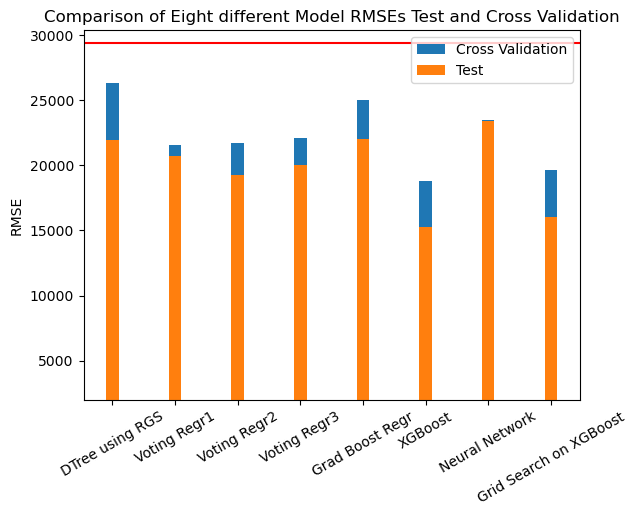

In [132]:

#Create the bar chart
fig, ax = plt.subplots()
bar_width = 0.2
bar1 = ax.bar(model_names, cross_val_rmse, bar_width, label='Cross Validation')
bar2 = ax.bar(model_names, test_list_rmse, bar_width, label='Test')
#plt.xticks(model_names, model_names, rotation=45)

#Add labels and title
plt.title('Comparison of Eight different Model RMSEs Test and Cross Validation')
ax.set_ylabel('RMSE')
plt.ylim(2000, baseline_test_rmse + 1000)
ax.legend()

#Define the Baseline test accuracy as reference
ax.axhline(y = baseline_test_rmse, color = 'r', linestyle = '-')

#Make the X axis more readable
plt.xticks(model_names, model_names, rotation=30)

#Show the chart
plt.show()

Cross-validation allows us to determine which models are overfitting the most and which are not. 